# BBC News Metin Sınıflandırma Projesi

Bu notebook'ta BBC News veri seti üzerinde metin sınıflandırma için EDA, gelişmiş ön işleme, farklı makine öğrenmesi modelleriyle eğitim ve karşılaştırma adımları yer almaktadır.

In [1]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import warnings
import xgboost
import lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from transformers import AutoTokenizer, AutoModel
import torch

## 1. Veri Yükleme ve İlk İnceleme

In [2]:
# Veri setini yükle
file_path = 'BBC News Train.csv'
data = pd.read_csv(file_path)
print(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## 2. EDA: Eksik Veri ve Sınıf Dağılımı

ArticleId    0
Text         0
Category     0
dtype: int64


ArticleId    0
Text         0
Category     0
dtype: int64


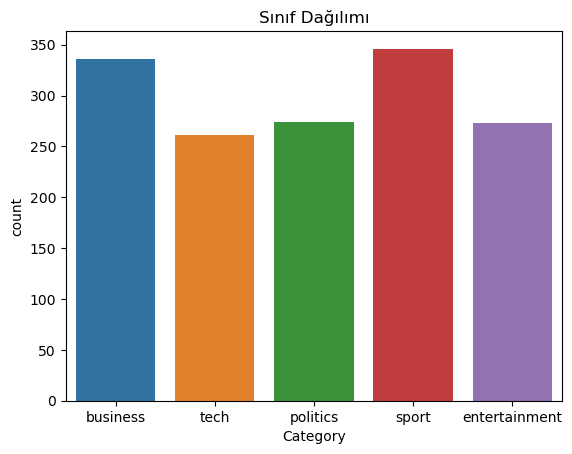

In [3]:
# Eksik değer kontrolü ve sınıf dağılımı
print(data.isnull().sum())
sns.countplot(x='Category', data=data)
plt.title('Sınıf Dağılımı')
plt.show()

## 3. Gelişmiş Ön İşleme

- Küçük harfe çevirme
- Noktalama ve sayı temizliği
- Kısa kelimeleri kaldırma
- Stopword temizliği
- Lemmatizasyon ve Stemming

In [4]:
# ArticleId kolonunu çıkar
if 'ArticleId' in data.columns:
    data = data.drop(columns=['ArticleId'])

from nltk.stem import PorterStemmer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text, use_stem=False):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Noktalama işaretlerini kaldır
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if len(w) > 2 and w not in stop_words]
    if use_stem:
        tokens = [stemmer.stem(w) for w in tokens]
    else:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    cleaned = ' '.join(tokens)
    return cleaned if cleaned.strip() else text

data['CleanText'] = data['Text'].apply(lambda x: clean_text(x, use_stem=False))
data['StemText'] = data['Text'].apply(lambda x: clean_text(x, use_stem=True))
display(data[['Text', 'CleanText', 'StemText']].head())

,Text,CleanText,StemText
0,worldcom ex-boss launches defence lawyers defe...,worldcom exboss launch defence lawyer defendin...,worldcom exboss launch defenc lawyer defend fo...
1,german business confidence slides german busin...,german business confidence slide german busine...,german busi confid slide german busi confid fe...
2,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizen majo...,bbc poll indic econom gloom citizen major nati...
3,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster better ...,lifestyl govern mobil choic faster better funk...
4,enron bosses in $168m payout eighteen former e...,enron boss payout eighteen former enron direct...,enron boss payout eighteen former enron direct...


## 4. Eğitim/Test Bölme

In [5]:
X = data['CleanText']
X_stem = data['StemText']
y = data['Category']

# XGBoost ve LightGBM için label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_stem, X_test_stem, _, _ = train_test_split(X_stem, y, test_size=0.2, random_state=42, stratify=y)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)
X_train_stem_enc, X_test_stem_enc, _, _ = train_test_split(X_stem, y_encoded, test_size=0.2, random_state=42, stratify=y)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (1192,) Test: (298,)


## 5. Farklı Modellerle Eğitim ve Karşılaştırma

- Logistic Regression
- Naive Bayes
- SVM
- Random Forest
- XGBoost
- LightGBM
- SGDClassifier
- KNN
- AdaBoost
- ExtraTrees

In [13]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42)
}

results = {}
reports = {}
for name, model in models.items():
    if name in ['XGBoost', 'LightGBM']:
        pipe1 = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000)),
            ('clf', model)
        ])
        pipe1.fit(X_train_enc, y_train_enc)
        y_pred1 = pipe1.predict(X_test_enc)
        f1_1 = classification_report(y_test_enc, y_pred1, target_names=le.classes_, output_dict=True)['weighted avg']['f1-score']

        pipe2 = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000)),
            ('clf', model)
        ])
        pipe2.fit(X_train_stem_enc, y_train_enc)
        y_pred2 = pipe2.predict(X_test_stem_enc)
        f1_2 = classification_report(y_test_enc, y_pred2, target_names=le.classes_, output_dict=True)['weighted avg']['f1-score']

        if f1_2 > f1_1:
            results[name + ' (stem)'] = f1_2
            reports[name + ' (stem)'] = classification_report(y_test_enc, y_pred2, target_names=le.classes_)
        else:
            results[name] = f1_1
            reports[name] = classification_report(y_test_enc, y_pred1, target_names=le.classes_)

        print(f'\n{name} (lemmatize) classification report:')
        print(classification_report(y_test_enc, y_pred1, target_names=le.classes_))
        print(f'\n{name} (stem) classification report:')
        print(classification_report(y_test_enc, y_pred2, target_names=le.classes_))

    else:
        pipe1 = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000)),
            ('clf', model)
        ])
        # Tüm sınıflar için eğitim!
        pipe1.fit(X_train, y_train)
        y_pred1 = pipe1.predict(X_test)
        f1_1 = classification_report(y_test, y_pred1, output_dict=True)['weighted avg']['f1-score']

        pipe2 = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000)),
            ('clf', model)
        ])
        pipe2.fit(X_train_stem, y_train)
        y_pred2 = pipe2.predict(X_test_stem)
        f1_2 = classification_report(y_test, y_pred2, output_dict=True)['weighted avg']['f1-score']

        if f1_2 > f1_1:
            results[name + ' (stem)'] = f1_2
            reports[name + ' (stem)'] = classification_report(y_test, y_pred2)
        else:
            results[name] = f1_1
            reports[name] = classification_report(y_test, y_pred1)

        print(f'\n{name} (lemmatize) classification report:')
        print(classification_report(y_test, y_pred1))
        print(f'\n{name} (stem) classification report:')
        print(classification_report(y_test, y_pred2))


Logistic Regression (lemmatize) classification report:
               precision    recall  f1-score   support

     business       0.94      0.99      0.96        67
entertainment       0.98      1.00      0.99        55
     politics       0.98      0.93      0.95        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298


Logistic Regression (stem) classification report:
               precision    recall  f1-score   support

     business       0.94      0.99      0.96        67
entertainment       0.98      1.00      0.99        55
     politics       0.98      0.93      0.95        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macr

c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:03:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:03:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:03:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (lemmatize) classification report:
               precision    recall  f1-score   support

     business       0.90      0.94      0.92        67
entertainment       0.98      0.95      0.96        55
     politics       0.96      0.93      0.94        55
        sport       0.94      0.99      0.96        69
         tech       0.90      0.87      0.88        52

     accuracy                           0.94       298
    macro avg       0.94      0.93      0.93       298
 weighted avg       0.94      0.94      0.94       298


XGBoost (stem) classification report:
               precision    recall  f1-score   support

     business       0.83      0.96      0.89        67
entertainment       0.98      0.95      0.96        55
     politics       0.96      0.89      0.92        55
        sport       0.97      0.97      0.97        69
         tech       0.94      0.87      0.90        52

     accuracy                           0.93       298
    macro avg       0.94      0.

## 6. Sonuçların Karşılaştırılması

,Model,F1 Score
6,SGDClassifier,0.979788
5,LightGBM (stem),0.976443
2,SVM,0.976369
1,Naive Bayes (stem),0.972970
0,Logistic Regression,0.969577
9,ExtraTrees,0.966465
3,Random Forest (stem),0.956449
4,XGBoost,0.936119
7,KNN (stem),0.936049
8,AdaBoost (stem),0.777136


,Model,F1 Score
6,SGDClassifier,0.979788
5,LightGBM (stem),0.976443
2,SVM,0.976369
1,Naive Bayes (stem),0.972970
0,Logistic Regression,0.969577
9,ExtraTrees,0.966465
3,Random Forest (stem),0.956449
4,XGBoost,0.936119
7,KNN (stem),0.936049
8,AdaBoost (stem),0.777136


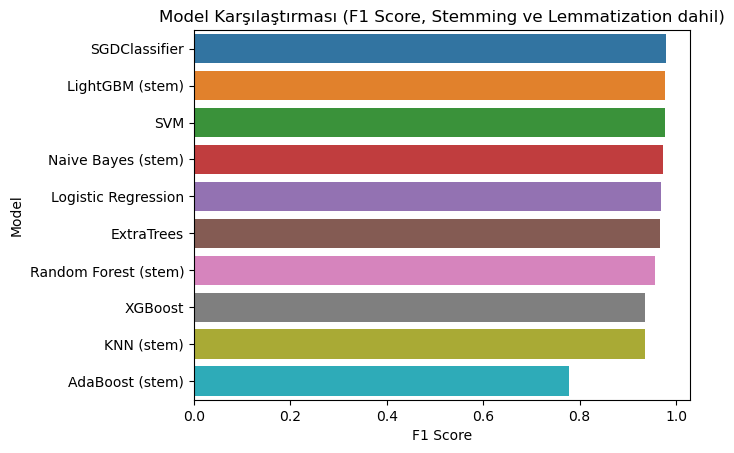


En iyi model: SGDClassifier

               precision    recall  f1-score   support

     business       0.99      0.99      0.99        67
entertainment       0.98      1.00      0.99        55
     politics       1.00      0.95      0.97        55
        sport       0.97      1.00      0.99        69
         tech       0.96      0.96      0.96        52

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



In [ ]:
result_df = pd.DataFrame(list(results.items()), columns=['Model', 'F1 Score'])
result_df = result_df.sort_values('F1 Score', ascending=False)
display(result_df)
sns.barplot(x='F1 Score', y='Model', data=result_df)
plt.title('Model Karşılaştırması (F1 Score, Stemming ve Lemmatization dahil)')
plt.show()

# En iyi modelin classification_report'unu göster
best_model = result_df.iloc[0]['Model']
print(f'\nEn iyi model: {best_model}\n')
print(reports[best_model])

## 6.1. F1 Skorunu 0.99'a Çıkarmak için Hiperparametre Optimizasyonu

In [7]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1,2),
        min_df=2,
        stop_words='english',
        sublinear_tf=True
    )),
    ('clf', SGDClassifier(random_state=42, early_stopping=True))
])

param_grid = {
    'clf__loss': ['log_loss', 'hinge'],
    'clf__penalty': ['l2', 'elasticnet'],
    'clf__alpha': [1e-4, 1e-5, 1e-6],
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

grid = GridSearchCV(pipeline, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
print('Weighted F1:', classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score'])

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'clf__alpha': 1e-05, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
               precision    recall  f1-score   support

     business       0.97      0.97      0.97        67
entertainment       0.96      1.00      0.98        55
     politics       0.96      0.95      0.95        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298

Weighted F1: 0.9695962917984263
Best params: {'clf__alpha': 1e-05, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
               precision    recall  f1-score   support

     business       0.97      0.97      0.97        

## 6.2. F1 Skorunu Tekrar Yükseltmek için En İyi Parametrelerle Eğitim

In [11]:
# En iyi parametrelerle SGDClassifier
# Tüm sınıflar için eğitim ve test

pipeline_best = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,1),
        min_df=1,
        stop_words=None
    )),
    ('clf', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-4,
        random_state=42,
        early_stopping=True
    ))
])

# y_train ve y_test zaten tüm sınıfları içeriyor!
pipeline_best.fit(X_train, y_train)
y_pred = pipeline_best.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
print('Weighted F1:', classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score'])

               precision    recall  f1-score   support

     business     0.9701    0.9701    0.9701        67
entertainment     0.9649    1.0000    0.9821        55
     politics     0.9623    0.9273    0.9444        55
        sport     0.9857    1.0000    0.9928        69
         tech     0.9608    0.9423    0.9515        52

     accuracy                         0.9698       298
    macro avg     0.9688    0.9679    0.9682       298
 weighted avg     0.9697    0.9698    0.9696       298

Weighted F1: 0.9696027747145757


### SGDClassifier'ı Tüm Sınıflar İçin Tekrar Eğitme

Aşağıda, eğitim setindeki tüm sınıfları kapsayacak şekilde SGDClassifier baştan eğitiliyor ve test setinde tahmin yapılıyor.

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Tüm sınıflar için SGDClassifier pipeline'ı baştan eğit
sgd_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,1),
        min_df=1,
        stop_words=None
    )),
    ('clf', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-4,
        random_state=42,
        early_stopping=True
    ))
])

sgd_pipeline.fit(X_train, y_train)
y_pred_sgd_all = sgd_pipeline.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_sgd_all, digits=4))

               precision    recall  f1-score   support

     business     0.9701    0.9701    0.9701        67
entertainment     0.9649    1.0000    0.9821        55
     politics     0.9623    0.9273    0.9444        55
        sport     0.9857    1.0000    0.9928        69
         tech     0.9608    0.9423    0.9515        52

     accuracy                         0.9698       298
    macro avg     0.9688    0.9679    0.9682       298
 weighted avg     0.9697    0.9698    0.9696       298



## 6.3. Bag of Words (CountVectorizer) ve TF-IDF Karşılaştırması

In [9]:
# TF-IDF ile SGDClassifier
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,1),
        min_df=1,
        stop_words=None
    )),
    ('clf', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-4,
        random_state=42,
        early_stopping=True
    ))
])
pipe_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipe_tfidf.predict(X_test)
print('TF-IDF Sonuçları:')
print(classification_report(y_test, y_pred_tfidf))
print('TF-IDF Weighted F1:', classification_report(y_test, y_pred_tfidf, output_dict=True)['weighted avg']['f1-score'])

# Bag of Words (CountVectorizer) ile SGDClassifier
pipe_bow = Pipeline([
    ('bow', CountVectorizer(
        max_features=5000,
        ngram_range=(1,1),
        min_df=1,
        stop_words=None
    )),
    ('clf', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-4,
        random_state=42,
        early_stopping=True
    ))
])
pipe_bow.fit(X_train, y_train)
y_pred_bow = pipe_bow.predict(X_test)
print('\nBag of Words Sonuçları:')
print(classification_report(y_test, y_pred_bow))
print('Bag of Words Weighted F1:', classification_report(y_test, y_pred_bow, output_dict=True)['weighted avg']['f1-score'])

TF-IDF Sonuçları:
               precision    recall  f1-score   support

     business       0.97      0.97      0.97        67
entertainment       0.96      1.00      0.98        55
     politics       0.96      0.93      0.94        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.94      0.95        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298

TF-IDF Weighted F1: 0.9696027747145757

Bag of Words Sonuçları:
               precision    recall  f1-score   support

     business       0.95      0.94      0.95        67
entertainment       0.96      0.98      0.97        55
     politics       0.91      0.95      0.93        55
        sport       0.99      0.99      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.96       298
    macro avg       0.96      0.9

## 6.4. CatBoostClassifier ile Sonuçlar

In [ ]:
from catboost import CatBoostClassifier

# TF-IDF vektörleri ile CatBoost (eski, sade hali)
tfidf_vec = TfidfVectorizer(max_features=5000, ngram_range=(1,1), min_df=1, stop_words=None)
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train_tfidf, y_train)
y_pred_catboost = catboost_model.predict(X_test_tfidf)
print('CatBoost (TF-IDF) Sonuçları:')
print(classification_report(y_test, y_pred_catboost))
print('CatBoost Weighted F1:', classification_report(y_test, y_pred_catboost, output_dict=True)['weighted avg']['f1-score'])

# Bag of Words (CountVectorizer) ile CatBoostClassifier (eski, sade hali)
bow_vec = CountVectorizer(max_features=5000, ngram_range=(1,1), min_df=1, stop_words=None)
X_train_bow = bow_vec.fit_transform(X_train)
X_test_bow = bow_vec.transform(X_test)

catboost_bow = CatBoostClassifier(verbose=0, random_state=42)
catboost_bow.fit(X_train_bow, y_train)
y_pred_catboost_bow = catboost_bow.predict(X_test_bow)
print('CatBoost (Bag of Words) Sonuçları:')
print(classification_report(y_test, y_pred_catboost_bow))
print('CatBoost BoW Weighted F1:', classification_report(y_test, y_pred_catboost_bow, output_dict=True)['weighted avg']['f1-score'])

CatBoost (TF-IDF) Sonuçları:
               precision    recall  f1-score   support

     business       0.93      0.99      0.96        67
entertainment       0.98      0.98      0.98        55
     politics       0.98      0.93      0.95        55
        sport       0.99      0.97      0.98        69
         tech       0.94      0.94      0.94        52

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298

CatBoost Weighted F1: 0.9631070944922339
CatBoost (Bag of Words) Sonuçları:
               precision    recall  f1-score   support

     business       0.93      0.99      0.96        67
entertainment       0.96      1.00      0.98        55
     politics       0.98      0.93      0.95        55
        sport       0.99      0.97      0.98        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.96       298
    macro 